In [23]:
import numpy as np
from sklearn.datasets import load_digits
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

In [24]:
def getDigitsDataset():
    digits = load_digits()
    data = digits.data
    target = digits.target
    # Convert to DataFrame for compatibility with your existing code
    feature_names = ['Pixel' + str(i) for i in range(data.shape[1])]
    df = pd.DataFrame(data, columns=feature_names)
    df['Target'] = target
    return df

In [25]:
def getTitanicDataset():
    # Load the dataset
    data = pd.read_csv('dataset/titanic.csv')
    
    # Drop the 'Name' column
    data.drop('Name', axis=1, inplace=True)
    
    # Move 'Survived' to the last column
    survived = data['Survived']
    data.drop('Survived', axis=1, inplace=True)
    data['Survived'] = survived
    
    # Handling categorical data: Convert 'Sex' to binary (0 for male, 1 for female)
    data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})
    
    return data

In [26]:
def splitDataset(dataset):
    feature = dataset.values[:, :-1]
    label = dataset.values[:, -1]
    feature_train, feature_test, label_train, label_test = train_test_split(feature, label, test_size=0.2)
    return feature_train, feature_test, label_train, label_test

In [27]:
class Node:
    def __init__(self, featureName=None, threshold=None, value=None, children=None, majorityLabel=None):
        self.featureName = featureName
        self.threshold = threshold
        self.value = value
        self.children = children or {}
        self.majorityLabel = majorityLabel

In [28]:
def calculateEntropy(labels):
    numClasses = Counter(labels)
    entropy = 0
    instanceCount = len(labels)
    for count in numClasses.values():
        probability = count / instanceCount
        entropy -= probability * np.log2(probability)
    return entropy

In [29]:
def calculateGini(labels):
    class_counts = Counter(labels)
    instances = len(labels)
    impurity = 1 - sum((count / instances) ** 2 for count in class_counts.values())
    return impurity

In [30]:
def calculateInfoGain(dataset, partitions):
    netDatasetEntropy = calculateEntropy(dataset[:, -1])
    return netDatasetEntropy - sum([(len(partition) / len(dataset)) * calculateEntropy(partition[:, -1]) for partition in partitions])

In [31]:
def calculateWeightedGini(partitions, dataset):
    total_instances = len(dataset)
    weighted_gini = sum((len(partition) / total_instances) * calculateGini(partition[:, -1]) for partition in partitions)
    return weighted_gini

In [32]:
def bootstrap_sample(dataset):
    n_samples = len(dataset)
    indices = np.random.choice(n_samples, size=n_samples, replace=True)
    return dataset.iloc[indices]

In [33]:
def selectAttribute(dataset, attributeList, attributeNames, criterion='infoGain'):
    bestMeasure = float('inf') if criterion == 'giniIndex' else float('-inf')
    bestAttributeIdx = None
    bestThreshold = None
    bestGain = 0

    m = int(np.sqrt(len(attributeList)))
    sampledAttributeList = np.random.choice(attributeList, size=m, replace=False)

    for attributeIdx in sampledAttributeList:
        columnData = dataset[:, attributeIdx]
        sortedValues = np.unique(columnData)
        is_numeric = np.issubdtype(columnData.dtype, np.number)

        for i in range(len(sortedValues) - 1):
            if is_numeric:
                value = (sortedValues[i] + sortedValues[i + 1]) / 2
            else:
                value = sortedValues[i]

            less = dataset[columnData <= value] if is_numeric else dataset[columnData == value]
            greater = dataset[columnData > value] if is_numeric else dataset[columnData != value]
            partitions = [less, greater]

            if criterion == 'infoGain':
                measure = calculateInfoGain(dataset, partitions)
            elif criterion == 'giniIndex':
                measure = calculateWeightedGini(partitions, dataset)
            else:
                raise ValueError("Invalid criterion")

            if (criterion == 'infoGain' and measure > bestMeasure) or (criterion == 'giniIndex' and measure < bestMeasure):
                bestMeasure = measure
                bestAttributeIdx = attributeIdx
                bestThreshold = value
                bestGain = measure

    if bestAttributeIdx is None:
        return None, None, None, None

    return bestAttributeIdx, attributeNames[bestAttributeIdx], bestThreshold, bestGain


In [34]:
def buildDecisionTree(dataset, attributeList, attributeNames, criterion='infoGain', depth=0, min_size=2, max_depth=7, min_gain=0.0001):
    majority_label = Counter(dataset[:, -1]).most_common(1)[0][0]

    if len(dataset) == 0 or len(set(dataset[:, -1])) == 1 or len(dataset) < min_size or depth >= max_depth or len(attributeList) == 0:
        return Node(value=majority_label, majorityLabel=majority_label)

    bestAttributeIdx, bestAttributeName, bestThreshold, gain = selectAttribute(dataset, attributeList, attributeNames, criterion)

    if bestAttributeIdx is None or gain <= min_gain:
        return Node(value=majority_label, majorityLabel=majority_label)

    node = Node(featureName=bestAttributeName, threshold=bestThreshold, majorityLabel=majority_label)

    # Recursively build the tree
    if bestThreshold is not None:
        left_partition = dataset[dataset[:, bestAttributeIdx] <= bestThreshold]
        right_partition = dataset[dataset[:, bestAttributeIdx] > bestThreshold]
        node.children['<='] = buildDecisionTree(left_partition, attributeList, attributeNames, criterion, depth+1, min_size, max_depth, min_gain) if len(left_partition) > 0 else None
        node.children['>'] = buildDecisionTree(right_partition, attributeList, attributeNames, criterion, depth+1, min_size, max_depth, min_gain) if len(right_partition) > 0 else None
    else:
        for value in np.unique(dataset[:, bestAttributeIdx]):
            partition = dataset[dataset[:, bestAttributeIdx] == value]
            node.children[value] = buildDecisionTree(partition, attributeList, attributeNames, criterion, depth+1, min_size, max_depth, min_gain) if len(partition) > 0 else None

    return node


In [35]:
def predictLabel(node, instance, attributeNames):
    if node.value is not None:
        return node.value

    attributeIdx = attributeNames.index(node.featureName)
    attributeValue = instance[attributeIdx]

    if node.threshold is not None:  # It's a numerical attribute
        if attributeValue <= node.threshold:
            child_key = '<='
        else:
            child_key = '>'
    else:  # It's a categorical attribute
        child_key = attributeValue

    if child_key in node.children:
        return predictLabel(node.children[child_key], instance, attributeNames)
    else:
        return node.majorityLabel

In [36]:
def calculateAccuracy(tree, features, labels, attributeNames):
    accuracyCount = 0
    for instance, originalLabel in zip(features, labels):
        observedLabel = predictLabel(tree, instance, attributeNames)
        if observedLabel == originalLabel:
            accuracyCount += 1
    accuracy = accuracyCount / len(labels)
    return accuracy

In [37]:
class RandomForest:
    def __init__(self, n_trees=10, criterion='infoGain', min_size=2, max_depth=7, min_gain=0.0001):
        self.n_trees = n_trees
        self.criterion = criterion
        self.min_size = min_size
        self.max_depth = max_depth
        self.min_gain = min_gain
        self.trees = []
        self.attributeNames = None

    def fit(self, features, target, attributeNames):
        self.attributeNames = attributeNames
        for _ in range(self.n_trees):
            sample_indices = np.random.choice(np.arange(len(features)), size=len(features), replace=True)
            sample_features = features[sample_indices]
            sample_target = target[sample_indices]
            tree = buildDecisionTree(np.column_stack((sample_features, sample_target)), list(range(len(attributeNames))), attributeNames, self.criterion, 0, self.min_size, self.max_depth, self.min_gain)
            self.trees.append(tree)

    def predict(self, instance):
        predictions = [predictLabel(tree, instance, self.attributeNames) for tree in self.trees]
        return Counter(predictions).most_common(1)[0][0]

In [38]:
def custom_stratified_kfold(X, y, n_splits=10):

    X, y = shuffle(X, y)
    folds = [[] for _ in range(n_splits)]
    
    # Get the indices for each class
    class_indices = {cls: np.where(y == cls)[0] for cls in np.unique(y)}
    
    # Distribute the indices of each class approximately equally to each fold
    for cls, indices in class_indices.items():
        np.random.shuffle(indices)
        for i, idx in enumerate(indices):
            folds[i % n_splits].append(idx)
    
    return folds

In [39]:
def calculate_metrics(predictions, actual):
    unique_labels = np.unique(np.concatenate([predictions, actual]))
    accuracy = np.mean(predictions == actual)
    
    precision_list = []
    recall_list = []
    for label in unique_labels:
        tp = np.sum((predictions == label) & (actual == label))
        fp = np.sum((predictions == label) & (actual != label))
        fn = np.sum((predictions != label) & (actual == label))
        tn = np.sum((predictions != label) & (actual != label))

        precision = tp / (tp + fp) if (tp + fp) != 0 else 0
        recall = tp / (tp + fn) if (tp + fn) != 0 else 0

        precision_list.append(precision)
        recall_list.append(recall)

    precision = np.mean(precision_list)
    recall = np.mean(recall_list)
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0

    return accuracy, precision, recall, f1

In [40]:
def cross_validate_random_forest(dataset, n_trees, n_splits=10, criterion='infoGain'):
    accuracies, precisions, recalls, f1scores = [], [], [], []


    data_array = dataset.to_numpy() if isinstance(dataset, pd.DataFrame) else dataset

    X = data_array[:, :-1]
    y = data_array[:, -1]

    folds = custom_stratified_kfold(X, y, n_splits=n_splits)

    for i in range(n_splits):
        train_indices = [idx for j, fold in enumerate(folds) if j != i for idx in fold]
        test_indices = folds[i]

        train_X, train_y = X[train_indices], y[train_indices]
        test_X, test_y = X[test_indices], y[test_indices]

        forest = RandomForest(n_trees=n_trees, criterion=criterion)
        attributeNames = list(range(X.shape[1]))  # Use column indices as attribute names
        forest.fit(train_X, train_y, attributeNames)

        predictions = np.array([forest.predict(instance) for instance in test_X])
        accuracy, precision, recall, f1 = calculate_metrics(predictions, test_y)
        
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1scores.append(f1)

    return np.mean(accuracies), np.mean(precisions), np.mean(recalls), np.mean(f1scores)

In [41]:
def print_metrics(accuracy, precision, recall, f1score, ntree):
    print("************NTree {}************\n".format(ntree))
    print("Avg Accuracy: {}\n".format(accuracy))
    print("Avg Precision: {}\n".format(precision))
    print("Avg Recall: {}\n".format(recall))
    print("Avg F1Score: {}\n".format(f1score))

In [42]:
def plot_metrics(ntree_list, accuracies, precisions, recalls, f1scores, dname, criterion):
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(ntree_list, accuracies, marker='o', linestyle='-')
    plt.title('{} Dataset using {} criterion Random Forest Accuracy vs Number of Trees'.format(dname, criterion))
    plt.xlabel('Number of Trees (ntree)')
    plt.ylabel('Accuracy')
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(ntree_list, precisions, marker='o', linestyle='-')
    plt.title('{} Dataset using {} criterion Random Forest Precision vs Number of Trees'.format(dname, criterion))
    plt.xlabel('Number of Trees (ntree)')
    plt.ylabel('Precision')
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(ntree_list, recalls, marker='o', linestyle='-')
    plt.title('{} Dataset using {} criterion Random Forest Recall vs Number of Trees'.format(dname, criterion))
    plt.xlabel('Number of Trees (ntree)')
    plt.ylabel('Recall')
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(ntree_list, f1scores, marker='o', linestyle='-')
    plt.title('{} Dataset using {} criterion Random Forest F1 Score vs Number of Trees'.format(dname, criterion))
    plt.xlabel('Number of Trees (ntree)')
    plt.ylabel('F1 Score')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [43]:
def startAlgo(voteData, dname, criterion='infoGain'):
    ntree_list = [10,30,50]
    # ntree_list = [10]
    n_splits = 10
    accuracies, precisions, recalls, f1scores = [], [], [], []
    print("########################### {} DataSet using {} criterion ###########################\n".format(dname, criterion))
    for ntree in ntree_list:
        accuracy, precision, recall, f1score = cross_validate_random_forest(voteData, ntree, n_splits, criterion)
        print_metrics(accuracy, precision, recall, f1score, ntree)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1scores.append(f1score)

    plot_metrics(ntree_list, accuracies, precisions, recalls, f1scores, dname, criterion)

########################### Digits DataSet using infoGain criterion ###########################

************NTree 10************

Avg Accuracy: 0.9332339290395743

Avg Precision: 0.9356166838279304

Avg Recall: 0.9315339239102531

Avg F1Score: 0.9335640581167135

************NTree 30************

Avg Accuracy: 0.9666305642411379

Avg Precision: 0.9654214941280832

Avg Recall: 0.9655001977058385

Avg F1Score: 0.9654557586650263

************NTree 50************

Avg Accuracy: 0.964320710327691

Avg Precision: 0.9652332222446942

Avg Recall: 0.9634852322338524

Avg F1Score: 0.9643500551609266



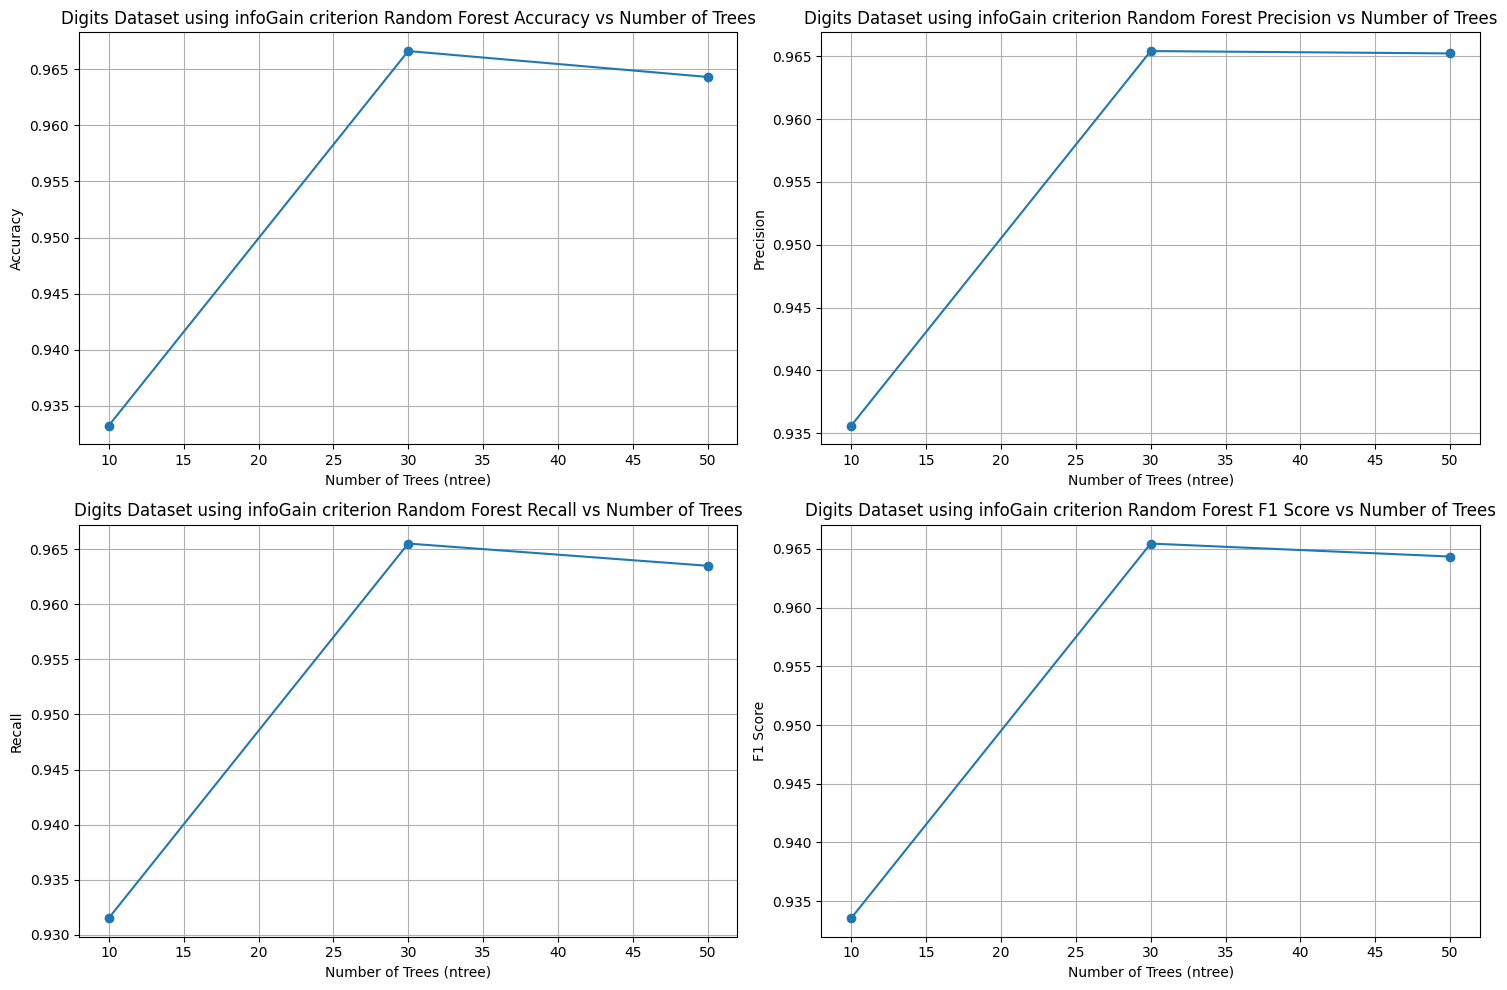

########################### Titanic DataSet using infoGain criterion ###########################

************NTree 10************

Avg Accuracy: 0.8285679832028148

Avg Precision: 0.832969196978125

Avg Recall: 0.8052169422476677

Avg F1Score: 0.8186443024042867

************NTree 30************

Avg Accuracy: 0.8261792078084212

Avg Precision: 0.8277116530837645

Avg Recall: 0.8017732764872546

Avg F1Score: 0.8144194443091969

************NTree 50************

Avg Accuracy: 0.8265100442628531

Avg Precision: 0.822334884785407

Avg Recall: 0.8037916045289724

Avg F1Score: 0.8128008397883646



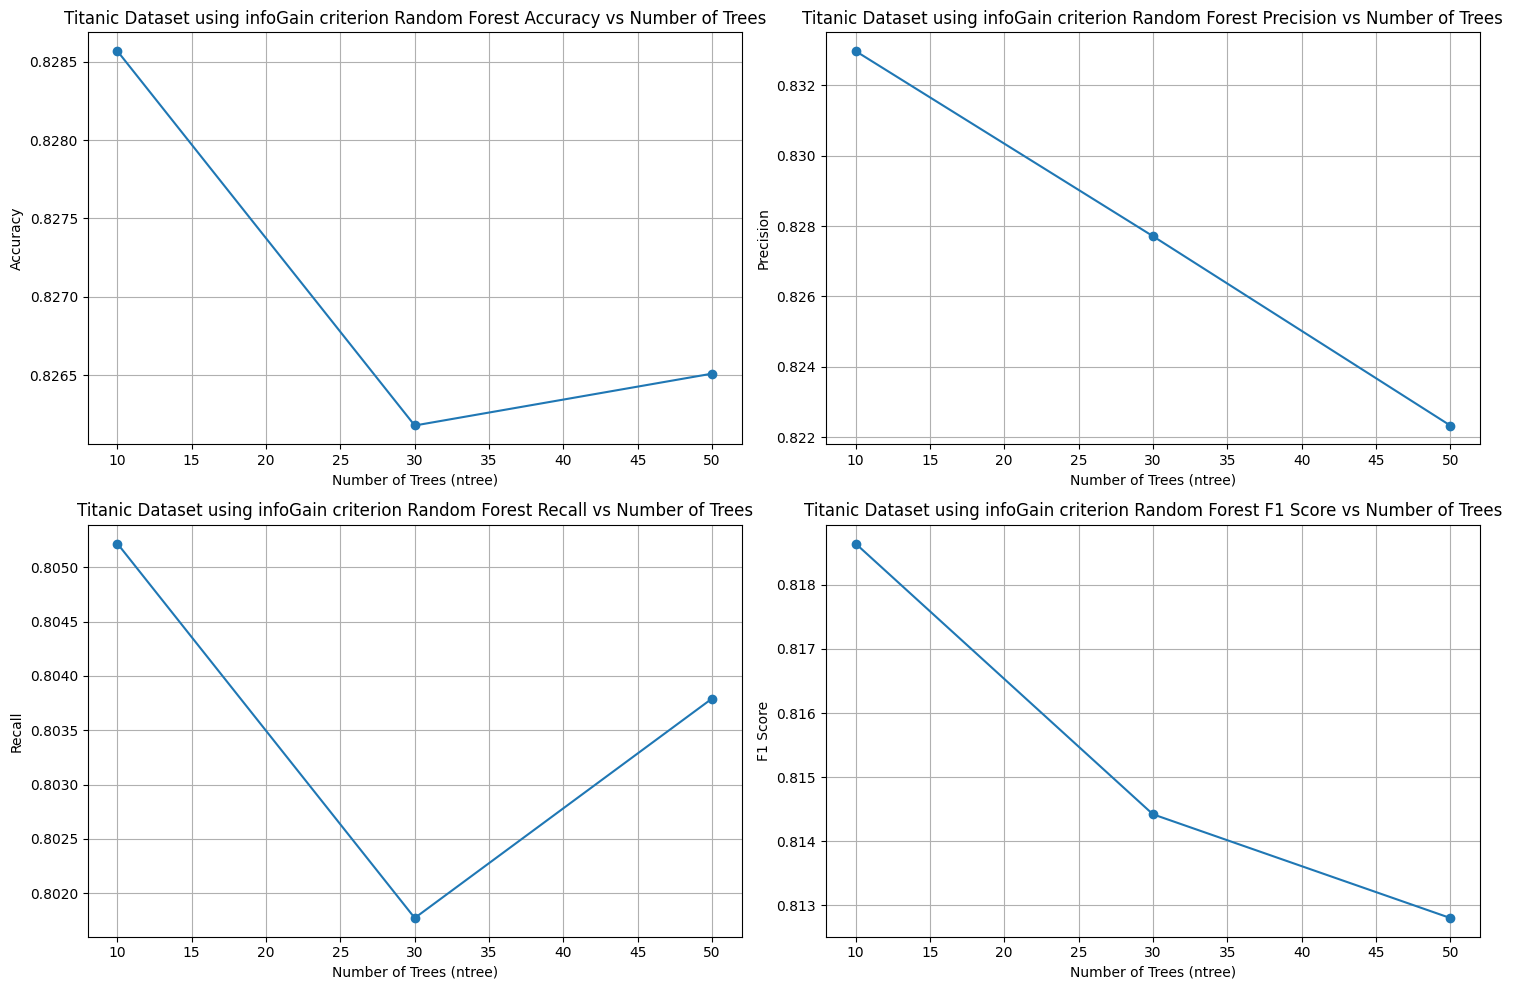

In [44]:
voteDataDigits = getDigitsDataset()
startAlgo(voteDataDigits, "Digits", "infoGain")
titanicData = getTitanicDataset()
startAlgo(titanicData, "Titanic", "infoGain")